# Data Ingest

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfhub

import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'

IMG_SIZE = (224,224)
CLASS_LABELS = ["Coast", "Desert", "Forest", "Glacier", "Mountain"]
BATCH_SIZE = 32
TF_RANDOM_SEED = 42

def make_data_gen(dir_location):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    return data_gen.flow_from_directory(dir_location,
                                              target_size=IMG_SIZE,
                                              classes=CLASS_LABELS,
                                              class_mode='sparse',
                                              seed=TF_RANDOM_SEED)
train_data = make_data_gen(TRAIN_DIR)

Found 10000 images belonging to 5 classes.


In [3]:
# TRAIN_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'

# IMG_SIZE = (224,224)
# CLASS_LABELS = ["Coast", "Desert", "Forest", "Glacier", "Mountain"]
# BATCH_SIZE = 32
# TF_RANDOM_SEED = 42

# def make_data_gen(dir_location):
# #     data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
# #     return data_gen.flow_from_directory(dir_location,
# #                                               target_size=IMG_SIZE,
# #                                               classes=CLASS_LABELS,
# #                                               class_mode='sparse',
# #                                               seed=TF_RANDOM_SEED)
#     return tf.keras.utils.image_dataset_from_directory(dir_location,
#                                                       seed=TF_RANDOM_SEED,
#                                                       image_size=IMG_SIZE,
#                                                       batch_size=BATCH_SIZE)
# train_data = make_data_gen(TRAIN_DIR)
# # make_data_gen(TRAIN_DIR)
# train_data.take(0).take(0)

In [4]:
# def show_batch_images(batch_dataset):
#     plt.subplots(4, 6)
    
#     for entries in batch_dataset.take(1):
# #         for image, label in entries:
# #             print(image.shape, label)
#         images, labels = entries
#         for image in images:
#             plt.imshow(image)
# #         print(entries[0].shape)
    
#     plt.axis('off')

# show_batch_images(train_data)

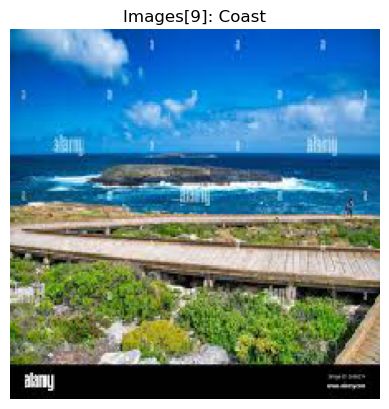

In [5]:
def show_random_image(dir_iter):
    batch_index = 0
    img_index = np.random.randint(32)
    label = CLASS_LABELS[int(dir_iter[batch_index][1][img_index])]

    plt.imshow(dir_iter[batch_index][0][img_index]/255.0)
    plt.title(f"Images[{img_index}]: {label}")
    plt.axis("off")
    plt.show()

show_random_image(train_data)

Found 1500 images belonging to 5 classes.


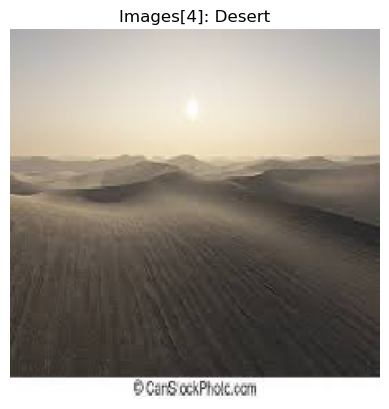

In [6]:
VALID_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Validation Data'

valid_data = make_data_gen(VALID_DIR)
show_random_image(valid_data)

Found 500 images belonging to 5 classes.


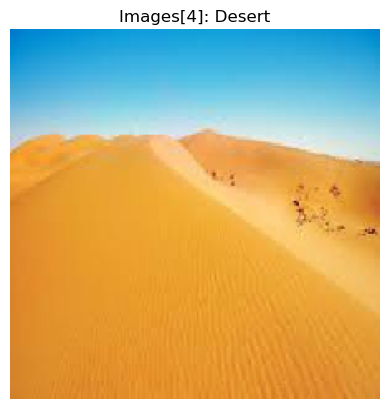

In [7]:
TEST_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Testing Data'

test_data = make_data_gen(TEST_DIR)
show_random_image(test_data)

# Model 1A - Efficient Nets with Feature Extraction

In [8]:
EPOCHS = 5

tf.random.set_seed(TF_RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))

basenet_model = tf.keras.applications.EfficientNetB0(include_top=False)
basenet_model.trainable = False
basenet_model = basenet_model(inputs)

outputs = tf.keras.layers.GlobalAveragePooling2D()(basenet_model)
outputs = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(outputs)

effnet_model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [9]:
def train_model(model, callbacks=[]):
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model.fit(train_data, 
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     steps_per_epoch=len(train_data),
                     validation_data=valid_data, 
                     validation_steps=int(0.25 * len(valid_data)),
                     callbacks=callbacks)

In [10]:
effnet_history = train_model(effnet_model)

Epoch 1/5
313/313 [==============================] - 55s 145ms/step - loss: 0.5520 - accuracy: 0.8233 - val_loss: 0.4964 - val_accuracy: 0.8239
Epoch 2/5
313/313 [==============================] - 27s 86ms/step - loss: 0.3557 - accuracy: 0.8814 - val_loss: 0.5211 - val_accuracy: 0.8153
Epoch 3/5
313/313 [==============================] - 28s 88ms/step - loss: 0.3181 - accuracy: 0.8975 - val_loss: 0.4721 - val_accuracy: 0.8381
Epoch 4/5
313/313 [==============================] - 27s 85ms/step - loss: 0.2977 - accuracy: 0.9006 - val_loss: 0.5021 - val_accuracy: 0.8153
Epoch 5/5
313/313 [==============================] - 28s 88ms/step - loss: 0.2796 - accuracy: 0.9068 - val_loss: 0.4456 - val_accuracy: 0.8352


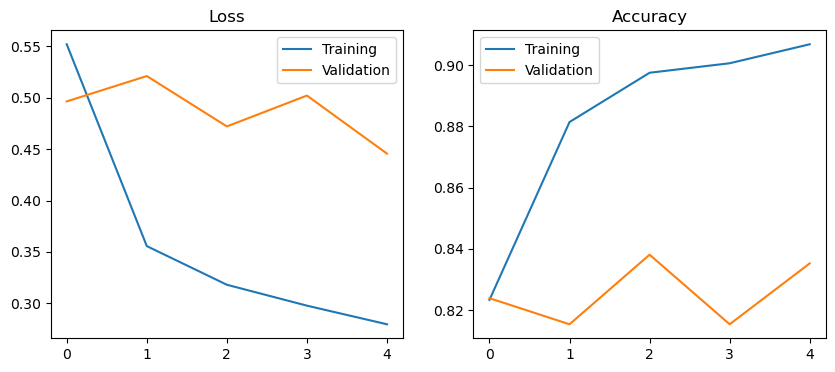

In [11]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label="Validation")
    plt.title("Accuracy")
    
    plt.legend()
    plt.show()
    
plot_history(effnet_history)

In [12]:
def evaluate_model(model):
    metrics = model.evaluate(test_data)
    print(f"Accuracy: {metrics[1] * 100:.2f}%")

evaluate_model(effnet_model)

16/16 [==============================] - 4s 260ms/step - loss: 0.2735 - accuracy: 0.9020
Accuracy: 90.20%


# Model 1B - EfficientNet with Data Augmentation


In [13]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
], name="augmentation_layers")

In [14]:
model1b_checkpoint_filepath = "model1b/best_model.ckpt"
model1b_checkpoint = tf.keras.callbacks.ModelCheckpoint(model1b_checkpoint_filepath,
                                                        save_best_only=True,
                                                        save_weights_only=False)

In [15]:
tf.random.set_seed(TF_RANDOM_SEED)
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

model_chain = base_model(model_chain)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
output_layer = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)


model1b = tf.keras.Model(inputs, output_layer)
model1b.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

In [16]:
model1b_history = train_model(model1b, [model1b_checkpoint])

Epoch 1/5
313/313 [==============================] - 79s 232ms/step - loss: 0.7219 - accuracy: 0.7416 - val_loss: 0.5963 - val_accuracy: 0.7898
Epoch 2/5
313/313 [==============================] - 71s 226ms/step - loss: 0.5384 - accuracy: 0.8058 - val_loss: 0.5940 - val_accuracy: 0.7812
Epoch 3/5
313/313 [==============================] - 72s 229ms/step - loss: 0.4996 - accuracy: 0.8204 - val_loss: 0.4834 - val_accuracy: 0.8125
Epoch 4/5
313/313 [==============================] - 32s 101ms/step - loss: 0.4813 - accuracy: 0.8261 - val_loss: 0.5407 - val_accuracy: 0.7983
Epoch 5/5
313/313 [==============================] - 31s 100ms/step - loss: 0.4570 - accuracy: 0.8360 - val_loss: 0.5857 - val_accuracy: 0.7841


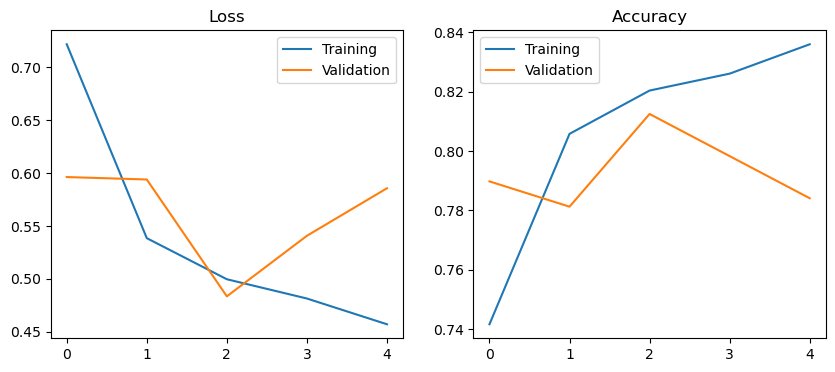

In [17]:
plot_history(model1b_history)

In [18]:
evaluate_model(model1b)

16/16 [==============================] - 1s 74ms/step - loss: 0.3807 - accuracy: 0.8500
Accuracy: 85.00%


# Model 1C - Fine-tuning layers

In [19]:
model1c = tf.keras.models.load_model(model1b_checkpoint_filepath)
model1c.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

In [20]:
evaluate_model(model1c)

16/16 [==============================] - 3s 81ms/step - loss: 0.3798 - accuracy: 0.8640
Accuracy: 86.40%


In [21]:
for i, layer in enumerate(model1c.layers):
    print(f"{i} {layer.name}: {layer.trainable}")

0 input_3: True
1 augmentation_layers: True
2 efficientnetb0: False
3 global_average_pooling2d_1: True
4 dense_1: True


In [22]:
tf.random.set_seed(TF_RANDOM_SEED)

model1c.layers[2].trainable = True
for i, layer in enumerate(model1c.layers[2].layers):
    layer.trainable = (i >= 227)
    
for i, layer in enumerate(model1c.layers[2].layers):
    print(f"{i} {layer.name}: {layer.trainable}")

0 input_4: False
1 rescaling_1: False
2 normalization_1: False
3 tf.math.truediv_1: False
4 stem_conv_pad: False
5 stem_conv: False
6 stem_bn: False
7 stem_activation: False
8 block1a_dwconv: False
9 block1a_bn: False
10 block1a_activation: False
11 block1a_se_squeeze: False
12 block1a_se_reshape: False
13 block1a_se_reduce: False
14 block1a_se_expand: False
15 block1a_se_excite: False
16 block1a_project_conv: False
17 block1a_project_bn: False
18 block2a_expand_conv: False
19 block2a_expand_bn: False
20 block2a_expand_activation: False
21 block2a_dwconv_pad: False
22 block2a_dwconv: False
23 block2a_bn: False
24 block2a_activation: False
25 block2a_se_squeeze: False
26 block2a_se_reshape: False
27 block2a_se_reduce: False
28 block2a_se_expand: False
29 block2a_se_excite: False
30 block2a_project_conv: False
31 block2a_project_bn: False
32 block2b_expand_conv: False
33 block2b_expand_bn: False
34 block2b_expand_activation: False
35 block2b_dwconv: False
36 block2b_bn: False
37 block2b_

In [23]:
model1c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model1c_history = model1c.fit(train_data,
                            epochs=EPOCHS + 5,
                            batch_size=BATCH_SIZE,
                            steps_per_epoch=len(train_data),
                            validation_data=valid_data,
                            validation_steps=int(0.25 * len(valid_data)),
                            initial_epoch=5)

Epoch 6/10
313/313 [==============================] - 41s 108ms/step - loss: 0.5021 - accuracy: 0.8187 - val_loss: 0.6765 - val_accuracy: 0.7898
Epoch 7/10
313/313 [==============================] - 31s 100ms/step - loss: 0.4440 - accuracy: 0.8430 - val_loss: 0.5274 - val_accuracy: 0.8097
Epoch 8/10
313/313 [==============================] - 31s 100ms/step - loss: 0.3961 - accuracy: 0.8607 - val_loss: 0.5622 - val_accuracy: 0.8153
Epoch 9/10
313/313 [==============================] - 32s 101ms/step - loss: 0.3757 - accuracy: 0.8657 - val_loss: 0.4702 - val_accuracy: 0.8523
Epoch 10/10
313/313 [==============================] - 32s 101ms/step - loss: 0.3505 - accuracy: 0.8802 - val_loss: 0.4340 - val_accuracy: 0.8381


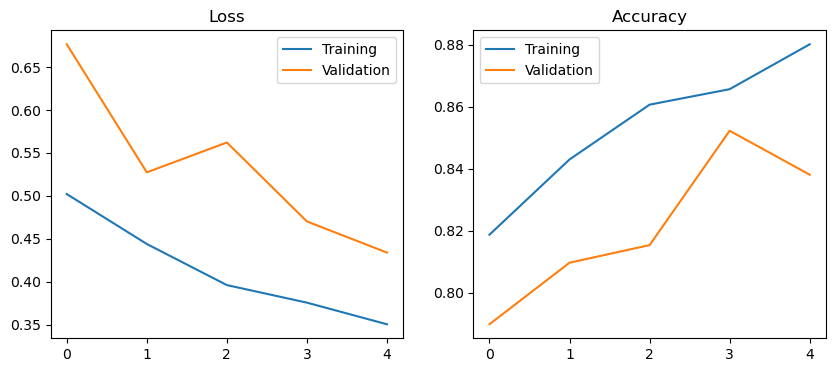

[5, 6, 7, 8, 9]

In [24]:
plot_history(model1c_history)
model1c_history.epoch

In [25]:
def plot_fine_tune_history(pre_history, post_history):
    fig, axs = plt.subplots( 1, 2,figsize=(10, 4))
    axs[0].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["loss"] + post_history.history["loss"],
            label="Training")
    axs[0].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["val_loss"] + post_history.history["val_loss"],
            label="Validation")
    axs[0].axvline(len(pre_history.epoch), 0, 1, color="red", linestyle="--")
    axs[0].set_title("Loss")
    axs[0].legend()
    
    axs[1].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["accuracy"] + post_history.history["accuracy"],
            label="Training")
    axs[1].plot(pre_history.epoch + post_history.epoch, 
            pre_history.history["val_accuracy"] + post_history.history["val_accuracy"],
            label="Validation")
    axs[1].axvline(len(pre_history.epoch), 0, 1, color="red", linestyle="--")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    
    plt.show()

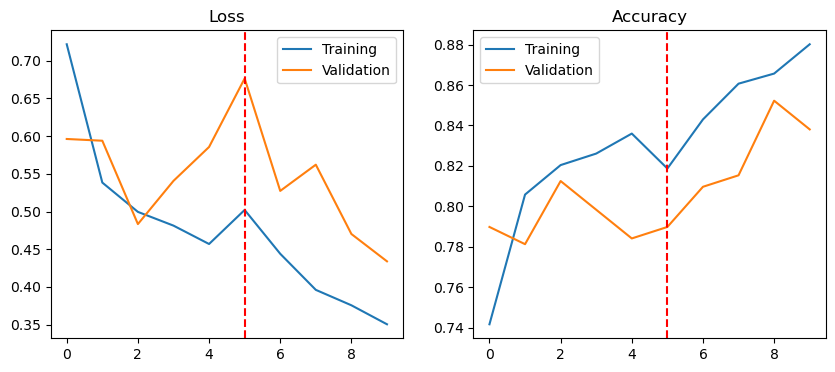

In [26]:
plot_fine_tune_history(model1b_history, model1c_history)

In [27]:
model1b_history.history["loss"]

[0.7218983173370361,
 0.5384388566017151,
 0.49957069754600525,
 0.48133546113967896,
 0.4569609463214874]

In [28]:
evaluate_model(model1c)

16/16 [==============================] - 1s 79ms/step - loss: 0.3087 - accuracy: 0.8760
Accuracy: 87.60%


# Model 2A - ResNet with Feature Extraction

In [29]:
tf.random.set_seed(TF_RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,))

model_chain = tf.keras.layers.Rescaling(1./255)(inputs)

base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.activity_regularizertrainable = False
model_chain = base_model(model_chain)

model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)

model2a = tf.keras.models.Model(inputs, model_chain)

94765736/94765736 [==============================] - 4s 0us/step


In [30]:
model2a_history = train_model(model2a)

Epoch 1/5
313/313 [==============================] - 64s 187ms/step - loss: 0.7840 - accuracy: 0.7386 - val_loss: 1.6922 - val_accuracy: 0.1733
Epoch 2/5
313/313 [==============================] - 58s 184ms/step - loss: 0.5559 - accuracy: 0.8061 - val_loss: 2.2538 - val_accuracy: 0.2017
Epoch 3/5
313/313 [==============================] - 57s 183ms/step - loss: 0.4484 - accuracy: 0.8473 - val_loss: 1.0485 - val_accuracy: 0.6222
Epoch 4/5
313/313 [==============================] - 57s 183ms/step - loss: 0.3940 - accuracy: 0.8648 - val_loss: 2.4270 - val_accuracy: 0.3750
Epoch 5/5
313/313 [==============================] - 57s 182ms/step - loss: 0.3565 - accuracy: 0.8773 - val_loss: 1.2172 - val_accuracy: 0.6392


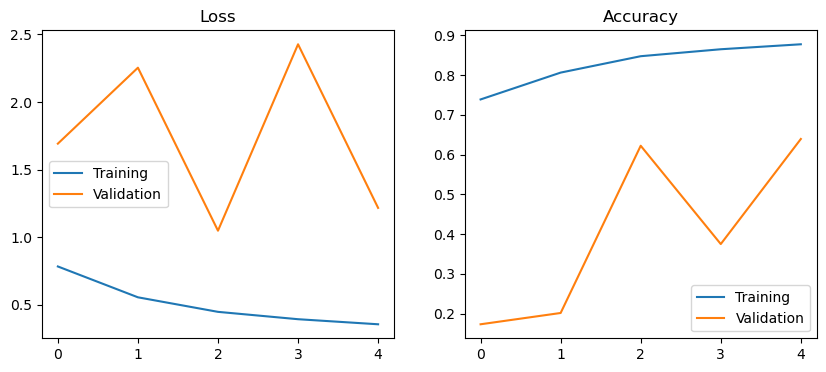

In [31]:
plot_history(model2a_history)

In [32]:
evaluate_model(model2a)

16/16 [==============================] - 2s 91ms/step - loss: 0.8708 - accuracy: 0.7140
Accuracy: 71.40%


# Model 2B - Resnet Model with Data Augmentation Layers

In [33]:
tf.random.set_seed(TF_RANDOM_SEED)

data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [34]:
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,))
model_chain = augmentation_layers(inputs)
model_chain = tf.keras.layers.Rescaling(1./255)(model_chain)

base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False
model_chain = base_model(model_chain)

model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(model_chain)
model2b = tf.keras.Model(inputs,  model_chain)

In [35]:
model2b_checkpoint_filepath = "model2b/best_model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model2b_checkpoint_filepath,
                                                     save_best_only=True,
                                                     save_wieght_only=True)
model2b_history = train_model(model2b, [model_checkpoint])

Epoch 1/5
313/313 [==============================] - 59s 179ms/step - loss: 1.5827 - accuracy: 0.2610 - val_loss: 1.5197 - val_accuracy: 0.3466
Epoch 2/5
313/313 [==============================] - 33s 106ms/step - loss: 1.5415 - accuracy: 0.3034 - val_loss: 1.5407 - val_accuracy: 0.2784
Epoch 3/5
313/313 [==============================] - 55s 175ms/step - loss: 1.5134 - accuracy: 0.3305 - val_loss: 1.5036 - val_accuracy: 0.3608
Epoch 4/5
313/313 [==============================] - 57s 181ms/step - loss: 1.4949 - accuracy: 0.3512 - val_loss: 1.4847 - val_accuracy: 0.3580
Epoch 5/5
313/313 [==============================] - 33s 106ms/step - loss: 1.4833 - accuracy: 0.3590 - val_loss: 1.4854 - val_accuracy: 0.3580


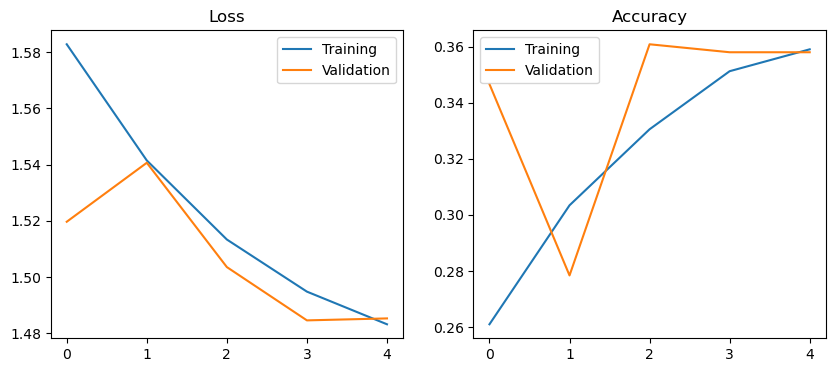

In [36]:
plot_history(model2b_history)

In [37]:
evaluate_model(model2b)

16/16 [==============================] - 1s 81ms/step - loss: 1.4426 - accuracy: 0.4120
Accuracy: 41.20%


# Model 3C - Resnet Model with Fine-Tuning

In [38]:
model2c = tf.keras.models.load_model(model2b_checkpoint_filepath)
evaluate_model(model2c)

16/16 [==============================] - 3s 85ms/step - loss: 1.4534 - accuracy: 0.4000
Accuracy: 40.00%


In [39]:
model2c.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layers (Sequen  (None, 224, 224, 3)      0         
 tial)                                                           
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 1024

In [40]:
for idx, layer in enumerate(model2c.layers):
    print(f"{idx} {layer.name}: {layer.trainable}")

0 input_7: True
1 augmentation_layers: True
2 rescaling_3: True
3 resnet50: False
4 global_average_pooling2d_3: True
5 dense_3: True


In [41]:
model2c.layers[3].trainable=True

for layer in model2c.layers[3].layers[:165]:
    layer.trainable = False

for layer in model2c.layers[3].layers[165:]:
    layer.trainable = True

In [42]:
for idx, layer in enumerate(model2c.layers[3].layers):
    print(f"{idx} {layer.name}: {layer.trainable}")

0 input_8: False
1 conv1_pad: False
2 conv1_conv: False
3 conv1_bn: False
4 conv1_relu: False
5 pool1_pad: False
6 pool1_pool: False
7 conv2_block1_1_conv: False
8 conv2_block1_1_bn: False
9 conv2_block1_1_relu: False
10 conv2_block1_2_conv: False
11 conv2_block1_2_bn: False
12 conv2_block1_2_relu: False
13 conv2_block1_0_conv: False
14 conv2_block1_3_conv: False
15 conv2_block1_0_bn: False
16 conv2_block1_3_bn: False
17 conv2_block1_add: False
18 conv2_block1_out: False
19 conv2_block2_1_conv: False
20 conv2_block2_1_bn: False
21 conv2_block2_1_relu: False
22 conv2_block2_2_conv: False
23 conv2_block2_2_bn: False
24 conv2_block2_2_relu: False
25 conv2_block2_3_conv: False
26 conv2_block2_3_bn: False
27 conv2_block2_add: False
28 conv2_block2_out: False
29 conv2_block3_1_conv: False
30 conv2_block3_1_bn: False
31 conv2_block3_1_relu: False
32 conv2_block3_2_conv: False
33 conv2_block3_2_bn: False
34 conv2_block3_2_relu: False
35 conv2_block3_3_conv: False
36 conv2_block3_3_bn: False
37

In [43]:
model2c.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model2c_history = model2c.fit(train_data,
                                epochs=EPOCHS+5,
                                steps_per_epoch=len(train_data),
                                validation_data=valid_data,
                                validation_steps=len(valid_data),
                                initial_epoch=5)

Epoch 6/10
313/313 [==============================] - 40s 117ms/step - loss: 1.2967 - accuracy: 0.4546 - val_loss: 1.9110 - val_accuracy: 0.2953
Epoch 7/10
313/313 [==============================] - 37s 118ms/step - loss: 1.1617 - accuracy: 0.5236 - val_loss: 1.2851 - val_accuracy: 0.4720
Epoch 8/10
313/313 [==============================] - 37s 117ms/step - loss: 1.1083 - accuracy: 0.5454 - val_loss: 1.4134 - val_accuracy: 0.4740
Epoch 9/10
313/313 [==============================] - 36s 115ms/step - loss: 1.0818 - accuracy: 0.5581 - val_loss: 2.3320 - val_accuracy: 0.3033
Epoch 10/10
313/313 [==============================] - 37s 118ms/step - loss: 1.0502 - accuracy: 0.5736 - val_loss: 1.3550 - val_accuracy: 0.4847


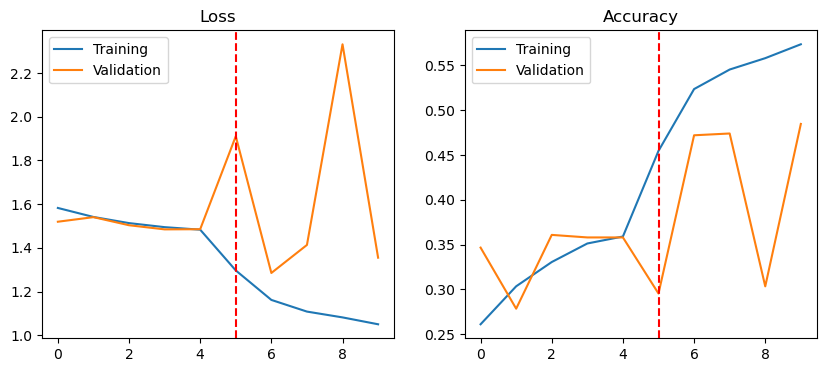

In [44]:
plot_fine_tune_history(model2b_history, model2c_history)

In [45]:
evaluate_model(model2c)

16/16 [==============================] - 1s 82ms/step - loss: 1.2697 - accuracy: 0.4960
Accuracy: 49.60%
